In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import geopandas as gpd
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import cartopy.crs as ccrs
from cartopy.crs import PlateCarree as plate
import cartopy.io.shapereader as shpreader

import xarray as xr
import atlite

import logging
import warnings

warnings.simplefilter('ignore')
logging.captureWarnings(False)
logging.basicConfig(level=logging.INFO)

In [2]:
shpfilename = shpreader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_map_subunits')
reader = shpreader.Reader(shpfilename)
Galapagos = gpd.GeoSeries({r.attributes['NAME_EN']: r.geometry
                      for r in reader.records()},
                     crs={'init': 'epsg:4326'}
                     ).reindex(['Galápagos Province'])
pd.options.display.max_seq_items = 355
print(gpd.GeoSeries({r.attributes['NAME_EN']: r.geometry
                      for r in reader.records()},
                     crs={'init': 'epsg:4326'}
                     ).index)
print(Galapagos)

Index(['Indonesia', 'Malaysia', 'Chile', 'Bolivia', 'Peru', 'Argentina',
       'Dhekelia Cantonment', 'Cyprus', 'India', 'People's Republic of China',
       'Israel', 'Gaza Strip', 'West Bank', 'Lebanon', 'Ethiopia',
       'South Sudan', 'Puntland', 'Somalia', 'Kenya', 'Malawi', 'Tanzania',
       'United Nations Disengagement Observer Force', 'Somaliland',
       'French Guiana', 'Suriname', 'Guyana', 'Korean Demilitarized Zone',
       'Morocco', 'Western Sahara', 'Costa Rica', 'Nicaragua',
       'Republic of the Congo', 'Democratic Republic of the Congo', 'Bhutan',
       'Ukraine', 'Belarus', 'Namibia', 'South Africa', 'Syria',
       'Saint Martin', 'Sint Maarten', 'Oman', 'Uzbekistan', 'Kazakhstan',
       'Tajikistan', 'Lithuania', 'Brazil', 'Uruguay', 'Mongolia', 'Russia',
       'Czech Republic', 'Germany', 'Estonia', 'Latvia', 'Norway', 'Sweden',
       'Finland', 'Vietnam', 'Cambodia', 'Luxembourg', 'United Arab Emirates',
       'France', 'Flemish Brabant', 'Walloon Bra

In [3]:
# Define the cutout; this will not yet trigger any major operations
cutout = atlite.Cutout(path="galapagos-2011",
                       module="era5",
                       bounds=Galapagos.unary_union.bounds,
                       time="2011")

# This is where all the work happens (this can take some time, for us it took ~15 minutes).
cutout.prepare()

INFO:atlite.data:Cutout already prepared.


<Cutout "galapagos-2011">
 x = -92.00 ⟷ -89.50, dx = 0.25
 y = -1.25 ⟷ 1.50, dy = 0.25
 time = 2011-01-01 ⟷ 2011-12-31, dt = H
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']

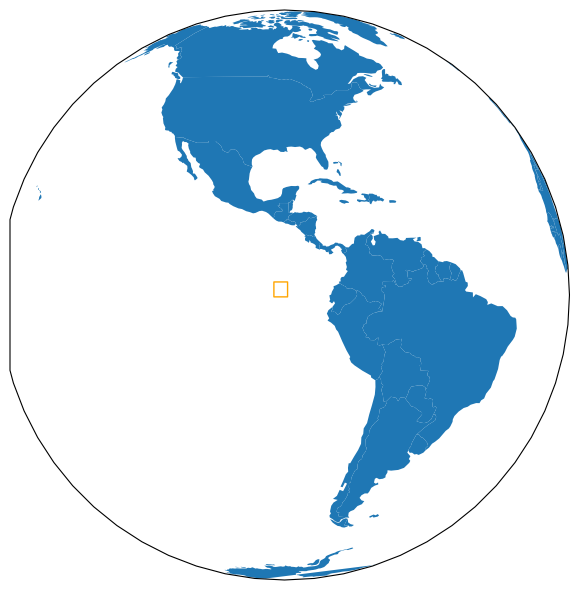

In [4]:
cells = cutout.grid
df = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
country_bound = gpd.GeoSeries(cells.unary_union)

projection = ccrs.Orthographic(-90, -1)
fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(6, 6))
df.plot(ax=ax, transform=plate())
country_bound.plot(ax=ax, edgecolor='orange',
                   facecolor='None', transform=plate())
fig.tight_layout()

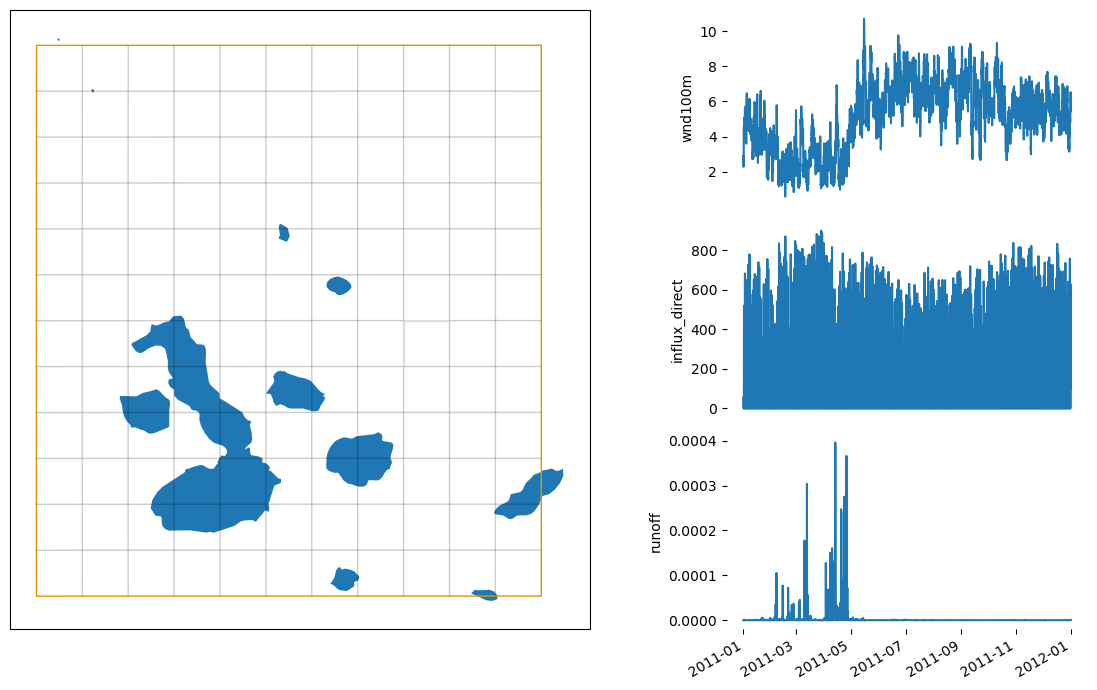

In [5]:
fig = plt.figure(figsize=(12, 7))
gs = GridSpec(3, 3, figure=fig)

ax = fig.add_subplot(gs[:, 0:2], projection=projection)
plot_grid_dict = dict(alpha=0.1, edgecolor='k', zorder=4, aspect='equal',
                      facecolor='None', transform=plate())
Galapagos.plot(ax=ax, zorder=1, transform=plate())
cells.plot(ax=ax, **plot_grid_dict)
country_bound.plot(ax=ax, edgecolor='orange',
                   facecolor='None', transform=plate())
# ax.outline_patch.set_edgecolor('white')

ax1 = fig.add_subplot(gs[0, 2])
cutout.data.wnd100m.mean(['x', 'y']).plot(ax=ax1)
ax1.set_frame_on(False)
ax1.xaxis.set_visible(False)

ax2 = fig.add_subplot(gs[1, 2], sharex=ax1)
cutout.data.influx_direct.mean(['x', 'y']).plot(ax=ax2)
ax2.set_frame_on(False)
ax2.xaxis.set_visible(False)

ax3 = fig.add_subplot(gs[2, 2], sharex=ax1)
cutout.data.runoff.mean(['x', 'y']).plot(ax=ax3)
ax3.set_frame_on(False)
ax3.set_xlabel(None)

fig.tight_layout()

INFO:atlite.convert:Convert and aggregate 'wind'.


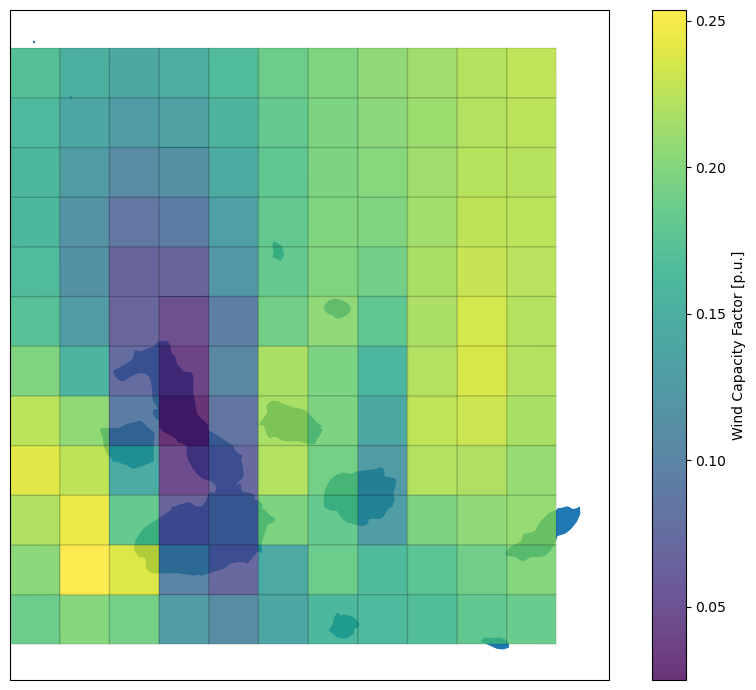

In [6]:
cap_factors = cutout.wind(turbine='Vestas_V112_3MW', capacity_factor=True)

fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(9, 7))
Galapagos.plot(ax=ax, zorder=1, transform=plate())
cap_factors.name = 'Wind Capacity Factor'
cap_factors.plot(ax=ax, transform=plate(), alpha=0.8)
cells.plot(ax=ax, **plot_grid_dict)
# ax.outline_patch.set_edgecolor('white')
fig.tight_layout()

INFO:atlite.convert:Convert and aggregate 'pv'.


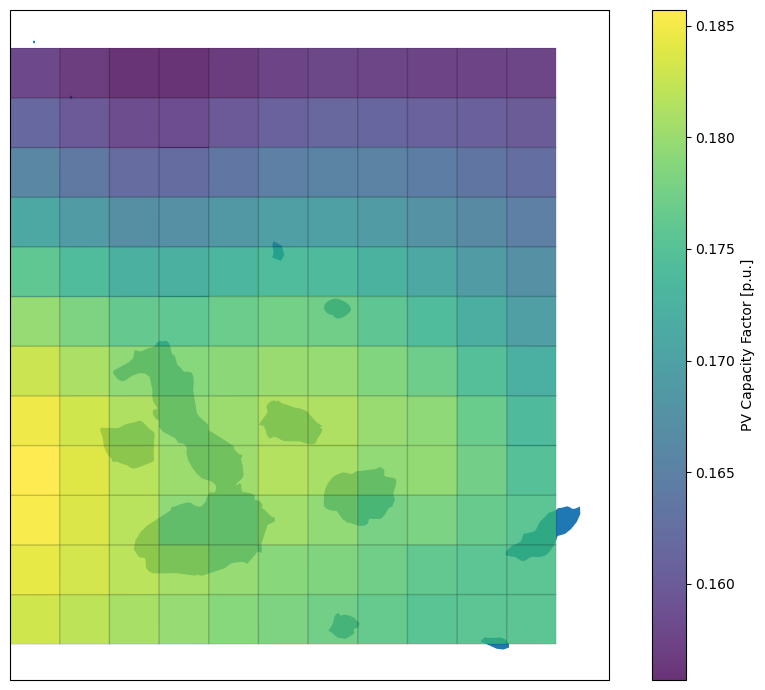

In [7]:
cap_factors = cutout.pv(panel="CSi", orientation={'slope': 30., 'azimuth': 180.}, capacity_factor=True)

fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(9, 7))
Galapagos.plot(ax=ax, zorder=1, transform=plate())
cap_factors.name = 'PV Capacity Factor'
cap_factors.plot(ax=ax, transform=plate(), alpha=0.8)
cells.plot(ax=ax, **plot_grid_dict)
# ax.outline_patch.set_edgecolor('white')
fig.tight_layout()

INFO:atlite.convert:Convert and aggregate 'wind'.


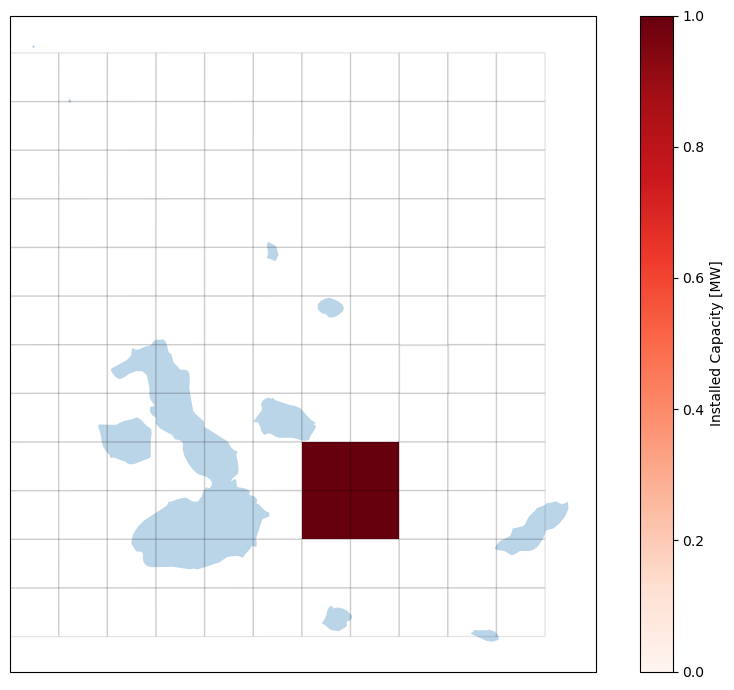

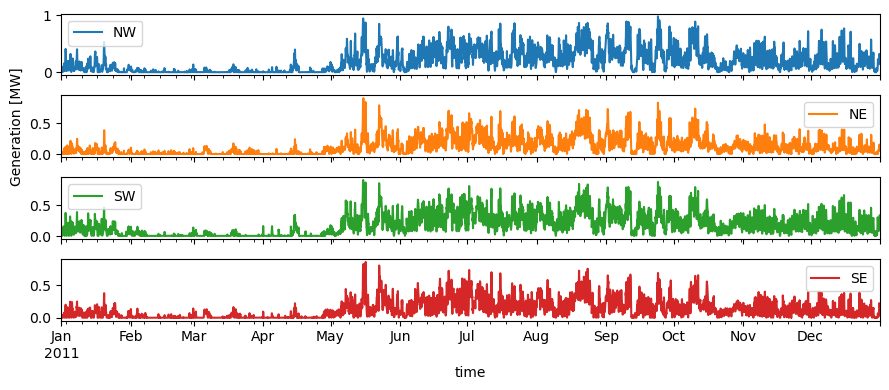

In [8]:
sites = gpd.GeoDataFrame(
    [
        ["NW", -90.44026, -0.46763,  1],
        ["NE", -90.23875, -0.47033,  1],
        ["SW", -90.44257, -0.71123,  1],
        ["SE", -90.24221, -0.69102,  1],
    ],
    columns=["name", "x", "y", "capacity"],
).set_index("name")

nearest = cutout.data.sel({"x": sites.x.values, "y": sites.y.values}, "nearest").coords
sites["x"] = nearest.get("x").values
sites["y"] = nearest.get("y").values
cells_generation = sites.merge(cells, how="inner").rename(pd.Series(sites.index))
layout = (
    xr.DataArray(cells_generation.set_index(["y", "x"]).capacity.unstack())
    .reindex_like(cap_factors)
    .rename("Installed Capacity [MW]")
)

fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=(9, 7))

Galapagos.plot(ax=ax, zorder=1, transform=plate(), alpha=0.3)
cells.plot(ax=ax, **plot_grid_dict)
layout.plot(
    ax=ax, transform=plate(), cmap="Reds", vmin=0, label="Installed Capacity [MW]"
)
# ax.outline_patch.set_edgecolor("white")
fig.tight_layout()

fig, axes = plt.subplots(len(sites), sharex=True, figsize=(9, 4))
power_generation = cutout.wind(
    "Vestas_V112_3MW", layout=layout, shapes=cells_generation.geometry
)
power_generation.to_pandas().to_csv('../Data/Wind_2011.csv')

power_generation.to_pandas().plot(subplots=True, ax=axes)
axes[2].set_xlabel("date")
axes[1].set_ylabel("Generation [MW]")
fig.tight_layout()

INFO:atlite.convert:Convert and aggregate 'pv'.


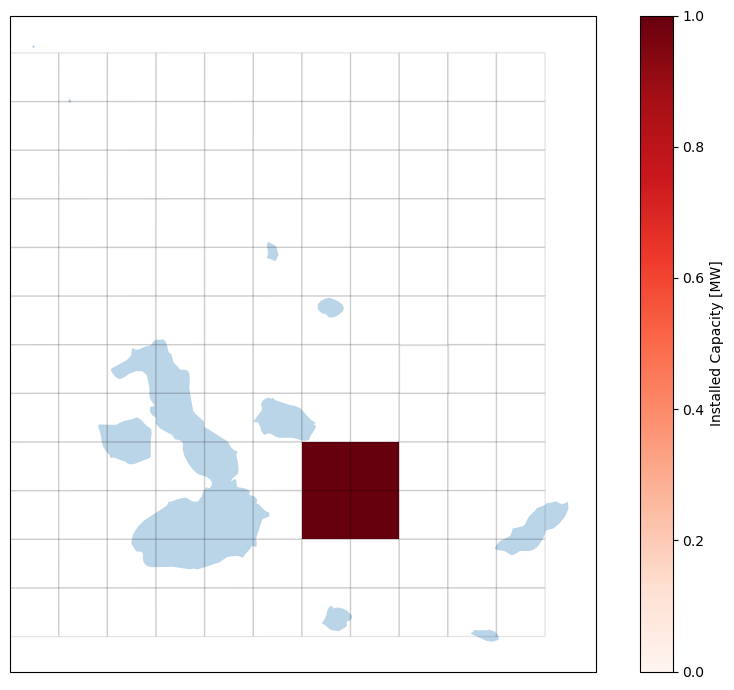

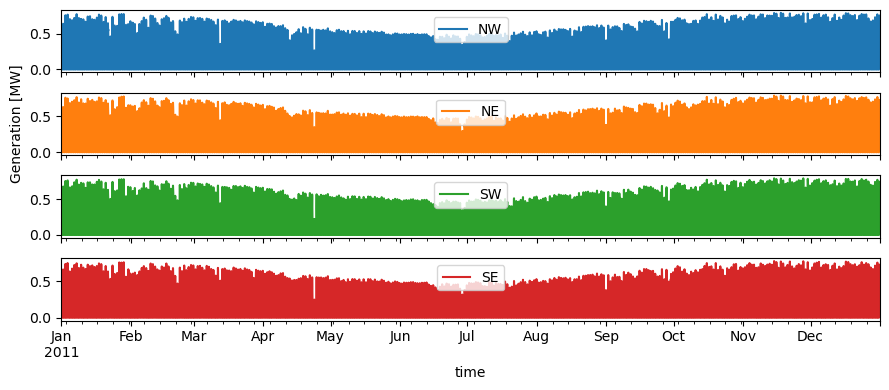

In [9]:
fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=(9, 7))

Galapagos.plot(ax=ax, zorder=1, transform=plate(), alpha=0.3)
cells.plot(ax=ax, **plot_grid_dict)
layout.plot(
    ax=ax, transform=plate(), cmap="Reds", vmin=0, label="Installed Capacity [MW]"
)
# ax.outline_patch.set_edgecolor("white")
fig.tight_layout()

fig, axes = plt.subplots(len(sites), sharex=True, figsize=(9, 4))

power_generation = cutout.pv(
    panel="CSi", orientation={'slope': 30., 'azimuth': 180.}, layout=layout, shapes=cells_generation.geometry
)

power_generation.to_pandas().plot(subplots=True, ax=axes)
power_generation.to_pandas().to_csv('../Data/PV_2011.csv')
axes[2].set_xlabel("date")
axes[1].set_ylabel("Generation [MW]")
fig.tight_layout()